In [ ]:
import zipfile

# Extracting ZIP file for the images and CSV file
with zipfile.ZipFile('/content/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

#**TASK 1 - Cancerous / Not Cancerous - Baseline Model**

**Imports**

In [ ]:
# Importing libraries

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets, layers, models
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

**Reading and Splitting Data**

In [ ]:
# reading the data from data_labels_mainData csv files 

data_main = pd.read_csv('/content/data_labels_mainData.csv')
data_main = data_main[['InstanceID','patientID','ImageName', 'isCancerous']]


# reading the data from data_labels_extraData csv files 
data_extra = pd.read_csv('/content/data_labels_extraData.csv')
data_extra = data_extra[['InstanceID','patientID','ImageName', 'isCancerous']]

data =data_extra
# concatinating the data 
# data = pd.concat([data_main, data_extra], axis=0)
data['isCancerous'] = data['isCancerous'].astype(str)


**Image Data Generator**

In [ ]:
# Real time data augmentation
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42,stratify= data['isCancerous'])
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=42, stratify= train_data['isCancerous'])
print("Train data : {}, Val Data: {}".format(train_data.shape[0], val_data.shape[0]))

train_datagen=ImageDataGenerator(zoom_range=0.1,shear_range=0.2,rescale=1/255,horizontal_flip=True)
# train_datagen=ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)


 
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

valid_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')


test_data['isCancerous'] = test_data['isCancerous'].astype(str)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27,27),
        batch_size=batch_size,
        class_mode='binary')

Train data : 7476, Val Data: 1869
Found 7476 validated image filenames belonging to 2 classes.
Found 1869 validated image filenames belonging to 2 classes.
Found 1039 validated image filenames belonging to 2 classes.


**Model - Baseline**

In [ ]:
#Creating new model and adding layers
baseModel= models.Sequential()
baseModel.add(Flatten(input_shape=(27,27,3)))
baseModel.add(Dense(256))
baseModel.add(Dense(1,activation='sigmoid'))

baseModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseModel.compile(optimizer='SGD',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

baseModelHistory = baseModel.fit(train_generator,
                                 validation_data=valid_generator,
                                 epochs=8)


Epoch 1/8
234/234 [==============================] - 11s 42ms/step - loss: 0.6942 - accuracy: 0.7235 - val_loss: 0.3762 - val_accuracy: 0.8566
Epoch 2/8
234/234 [==============================] - 9s 38ms/step - loss: 0.4194 - accuracy: 0.8074 - val_loss: 0.3351 - val_accuracy: 0.8614
Epoch 3/8
234/234 [==============================] - 8s 34ms/step - loss: 0.3750 - accuracy: 0.8363 - val_loss: 0.3700 - val_accuracy: 0.8325
Epoch 4/8
234/234 [==============================] - 10s 42ms/step - loss: 0.3416 - accuracy: 0.8514 - val_loss: 0.3243 - val_accuracy: 0.8566
Epoch 5/8
234/234 [==============================] - 11s 46ms/step - loss: 0.3316 - accuracy: 0.8578 - val_loss: 0.2969 - val_accuracy: 0.8727
Epoch 6/8
234/234 [==============================] - 9s 39ms/step - loss: 0.3293 - accuracy: 0.8558 - val_loss: 0.3122 - val_accuracy: 0.8662
Epoch 7/8
234/234 [==============================] - 9s 37ms/step - loss: 0.3131 - accuracy: 0.8625 - val_loss: 0.3403 - val_accuracy: 0.8432
Epo

**Plotting Metrics**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def evaluate_model(model, model_name, test_generator, valid_generator, train_generator):
    # Get predictions for test, validation, and train data
    test_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
    test_predictions = model.predict(test_generator) 

    validation_labels = np.concatenate([valid_generator[i][1] for i in range(len(valid_generator))])
    val_predictions = model.predict(valid_generator) 

    train_labels = np.concatenate([train_generator[i][1] for i in range(len(train_generator))])
    train_predictions = model.predict(train_generator)

    # Confusion Matrix
    test_cm = confusion_matrix(test_labels, test_predictions > 0.5)
    val_cm = confusion_matrix(validation_labels, val_predictions > 0.5)
    train_cm = confusion_matrix(train_labels, train_predictions > 0.5)

    # ROC Curve
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_predictions)
    val_fpr, val_tpr, _ = roc_curve(validation_labels, val_predictions)
    train_fpr, train_tpr, _ = roc_curve(train_labels, train_predictions)

    test_auc = auc(test_fpr, test_tpr)
    val_auc = auc(val_fpr, val_tpr)
    train_auc = auc(train_fpr, train_tpr)

    # Calculate performance metrics for test data
    accuracy_test = (test_cm[0, 0] + test_cm[1, 1]) / sum(sum(test_cm))
    precision_test = test_cm[1, 1] / (test_cm[1, 1] + test_cm[0, 1])
    recall_test = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0])
    specificity_test = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1])
    f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)

    # Calculate performance metrics for validation data
    accuracy_val = (val_cm[0, 0] + val_cm[1, 1]) / sum(sum(val_cm))
    precision_val = val_cm[1, 1] / (val_cm[1, 1] + val_cm[0, 1])
    recall_val = val_cm[1, 1] / (val_cm[1, 1] + val_cm[1, 0])
    specificity_val = val_cm[0, 0] / (val_cm[0, 0] + val_cm[0, 1])
    f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)

    # Calculate performance metrics for train data
    accuracy_train = (train_cm[0, 0] + train_cm[1, 1]) / sum(sum(train_cm))
    precision_train = train_cm[1, 1] / (train_cm[1, 1] + train_cm[0, 1])
    recall_train = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0])
    specificity_train = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1])
    f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

    # Set the column width for alignment
    column_width = 20

    # Print performance metrics for test data
    print(f'{model_name}-Test,Validation and Train Metrics'.center(column_width*3))
    print(f" Test Model: {model_name:<{column_width}}\tValidation: {model_name:<{column_width}}\t\tTrain: {model_name}")
    print(f" Test Accuracy: {accuracy_test:<{column_width}.4f}\tValidation Accuracy: {accuracy_val:<{column_width}.4f}\tTrain Accuracy: {accuracy_train:.4f}")
    print(f" Test Precision: {precision_test:<{column_width}.4f}\tValidation Precision: {precision_val:<{column_width}.4f}\tTrain Precision: {precision_train:.4f}")
    print(f" Test Recall: {recall_test:<{column_width}.4f}\tValidation Recall: {recall_val:<{column_width}.4f}\t\tTrain Recall: {recall_train:.4f}")
    print(f" Test Specificity: {specificity_test:<{column_width}.4f}\tValidation Specificity: {specificity_val:<{column_width}.4f}\tTrain Specificity: {specificity_train:.4f}")
    print(f" Test F1 Score: {f1_score_test:<{column_width}.4f}\tValidation F1 Score: {f1_score_val:<{column_width}.4f}\tTrain F1 Score: {f1_score_train:.4f}")


    # Plotting
    # Confusion Matrix
    plt.figure(figsize=(20, 2))
    plt.subplot(1, 4, 1)
    plt.title(f'{model_name} - Test Confusion Matrix', fontsize=8)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 4, 2)
    plt.title(f'{model_name} - Validation Confusion Matrix', fontsize=8)
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.subplot(1, 4, 3)
    plt.title(f'{model_name} - Train Confusion Matrix', fontsize=8)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # ROC Curve
    plt.subplot(1, 4, 4)
    plt.plot(test_fpr, test_tpr, label=f'Test ROC Curve (AUC = {test_auc:.2f})')
    plt.plot(val_fpr, val_tpr, label=f'Validation ROC Curve (AUC = {val_auc:.2f})')
    plt.plot(train_fpr, train_tpr, label=f'Train ROC Curve (AUC = {train_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve', fontsize=10)
    plt.legend()
    plt.show()







234/234 [==============================] - 8s 33ms/step
       base Model -Test,Validation and Train Metrics        
 Test Model: base Model          	Validation: base Model          		Train: base Model 
 Test Accuracy: 0.8951              	Validation Accuracy: 0.8727              	Train Accuracy: 0.8799
 Test Precision: 0.8571              	Validation Precision: 0.8151              	Train Precision: 0.8220
 Test Recall: 0.7625              	Validation Recall: 0.7212              		Train Recall: 0.7441
 Test Specificity: 0.9486              	Validation Specificity: 0.9339              	Train Specificity: 0.9348
 Test F1 Score: 0.8071              	Validation F1 Score: 0.7653              	Train F1 Score: 0.7811


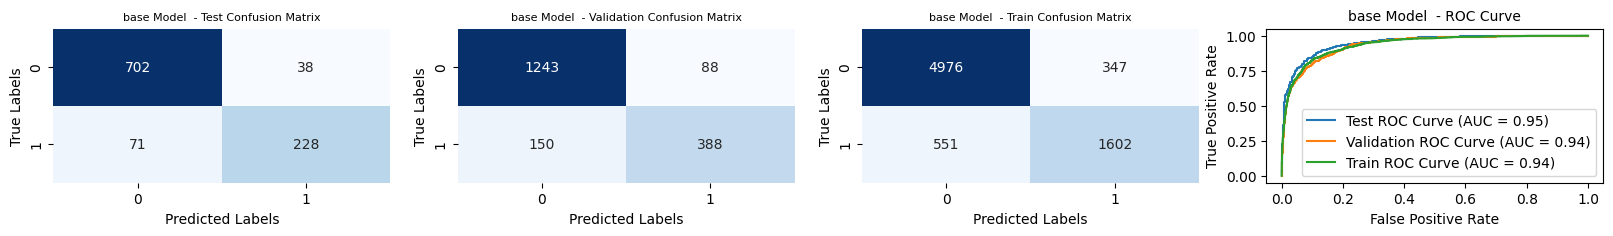

In [ ]:
evaluate_model(baseModel, "base Model ", test_generator, valid_generator, train_generator)